In [2]:
# https://github.com/pytorch/examples/blob/main/mnist/main.py

from random import shuffle
import uuid
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
import os
from uuid import uuid4

import numpy as np
from datetime import datetime

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

mnist_mean, mnist_std = (0.1307,), (0.3081,)
mnist_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
    ])
mnist_train = datasets.MNIST('../../data', train=True, download=True,
                    transform=mnist_transform)

mnist_train, mnist_val = random_split(mnist_train, [int(.9*len(mnist_train)),int(.1*len(mnist_train))], generator=torch.Generator().manual_seed(10708))
mnist_test = datasets.MNIST('../../data', train=False,
                    transform=mnist_transform)


c:\Users\Manley\miniconda3\envs\10707\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:

baseline_sample_counts = [16, 32, 64, 128, 256]

baseline_performances = {
    'sample_IID': {
        'acc': [],
        'loss': []
    }
}
for count in baseline_sample_counts:
    baseline_performances[f'sample_filters_IID_{count}'] = {}
    baseline_performances[f'sample_filters_IID_{count}']['acc'] = []
    baseline_performances[f'sample_filters_IID_{count}']['loss'] = []




batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_val,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True)


In [4]:
# Training params

import pickle

lr = 1e-2
repetitions = 1
baseline_performances = {}
start_training = datetime.now()
for hidden in [8,16,32,64]:
    for epoch in range(4, 30, 5):
        baseline_performances[f'{hidden}_{epoch}'] = {
            'acc': [],
            'loss': []
        }

        uuids = os.listdir(f'../../filters/{hidden}_{epoch}/')
        for uuid in uuids:

            # Sample full baseline
            # uuid = np.random.choice(uuids, replace=True)

            net = nn.Sequential(
                nn.Conv2d(1, hidden, kernel_size=5, stride=2, bias=False),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(144*hidden, 10)
            ).to(device)

            net.load_state_dict(torch.load(f'../../filters/{hidden}_{epoch}/{uuid}'))

            net.eval()
            num_correct, num_all, test_loss = 0, 0, 0
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(test_loader):
                    data, target = data.to(device), target.to(device)
                    output = net(data)
                    preds = output.argmax(dim=1)
                    num_correct += np.count_nonzero(target.cpu().numpy() == preds.cpu().numpy())
                    num_all += len(target)
                    test_loss += F.nll_loss(output, target)

            acc = num_correct / num_all
            test_loss = test_loss / num_all
            baseline_performances[f'{hidden}_{epoch}']['acc'].append(acc)
            baseline_performances[f'{hidden}_{epoch}']['loss'].append(test_loss)
            # print(repetition+1, 'full', acc)

            # for count in baseline_sample_counts:
            #     # Sample full baseline

            #     net = nn.Sequential(
            #         nn.Conv2d(1, count, kernel_size=5, stride=2, bias=False),
            #         nn.ReLU(),
            #         nn.Flatten(),
            #         nn.Linear(2304, 10)
            #     ).to(device)

            #     with torch.no_grad():
            #         for c in range(count):
            #             uuid = np.random.choice(uuids, replace=True)
            #             filter_choice_i = np.random.choice(16)
            #             net[0].weight[c,:,:,:] = torch.load(f'../../filters/{uuid}')['0.weight'][filter_choice_i]

            #     optimizer = optim.Adadelta(net.parameters(), lr=lr)

            #     # https://github.com/pytorch/examples/blob/main/mnist/main.py

            #     net.train()
            #     val_losses = []
            #     epoch = 0
            #     while True:
                    
            #         net.train()
            #         for layer in net[0:3]:
            #             layer.requires_grad = False
            #         net[3].requires_grad = True
            #         print(f'Repetition {repetition+1} of {repetitions}, Count of filters {count}, Epoch {epoch+1} , {datetime.now() - start_training}')
            #         print(val_losses[-10:])
            #         for batch_idx, (data, target) in enumerate(train_loader):
            #             data, target = data.to(device), target.to(device)
            #             optimizer.zero_grad()
            #             output = net(data)
            #             loss = F.nll_loss(output, target)
            #             loss.backward()
            #             optimizer.step()

            #         net.eval()
            #         num_correct, num_all, val_loss = 0, 0, 0
            #         with torch.no_grad():
            #             for batch_idx, (data, target) in enumerate(val_loader):
            #                 data, target = data.to(device), target.to(device)
            #                 output = net(data)
            #                 preds = output.argmax(dim=1)
            #                 num_correct += np.count_nonzero(target.cpu().numpy() == preds.cpu().numpy())
            #                 num_all += len(target)
            #                 val_loss += F.nll_loss(output, target)

            #         val_losses.append(val_loss)

            #         if len(val_losses)>=2 and val_losses[-1] > val_losses[-2]:
            #             print(len(val_losses))
            #             break
            #         epoch += 1


            #     # Final eval on Test

            #     net.eval()
            #     num_correct, num_all, test_loss = 0, 0, 0
            #     with torch.no_grad():
            #         for batch_idx, (data, target) in enumerate(test_loader):
            #             data, target = data.to(device), target.to(device)
            #             output = net(data)
            #             preds = output.argmax(dim=1)
            #             num_correct += np.count_nonzero(target.cpu().numpy() == preds.cpu().numpy())
            #             num_all += len(target)
            #             test_loss += F.nll_loss(output, target)

            #     acc = num_correct / num_all
            #     test_loss = test_loss / num_all
            #     baseline_performances[f'sample_filters_IID_{count}']['acc'].append(acc)
            #     baseline_performances[f'sample_filters_IID_{count}']['loss'].append(test_loss)

            #     with open('save_baselines.pickle', 'wb') as handle:
            #         pickle.dump(baseline_performances, handle, protocol=pickle.HIGHEST_PROTOCOL)


10
10
10
10


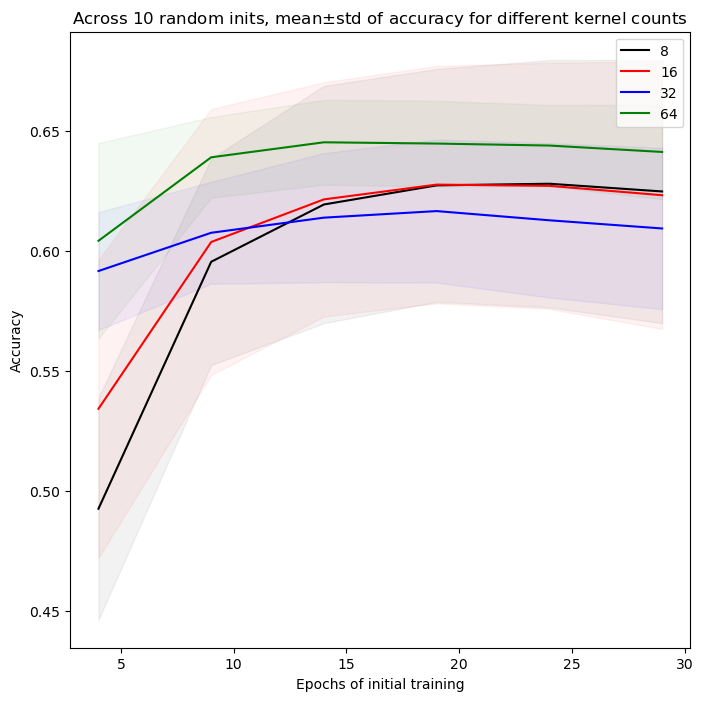

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

for hidden, color in zip([8,16,32,64],['black','red','blue','green']):
    epoch_range = list(range(4, 30, 5))
    accs = np.array([np.mean(baseline_performances[f'{hidden}_{epoch}']['acc']) for epoch in range(4, 30, 5)])
    stds = np.array([np.std(baseline_performances[f'{hidden}_{epoch}']['acc']) for epoch in range(4, 30, 5)])
    print(len(baseline_performances[f'{hidden}_{epoch}']['acc']))
    plt.plot(epoch_range, accs, label=hidden, color=color)
    plt.fill_between(epoch_range, accs - stds,accs+stds, color = color, alpha=0.05)

plt.legend()
plt.xlabel('Epochs of initial training')
plt.ylabel('Accuracy')
plt.title(r'Across 10 random inits, mean$\pm$std of accuracy for different kernel counts')
plt.show()